In [479]:
from groupdotplot import groupdotplot

In [476]:
# For development purpose, no need to include in real code
%load_ext autoreload
%autoreload 2

In [528]:
n = 200 # 100 clonotypes
idlist = []
conditionlist = []
for i in range(n):
    idlist += [str(i)] * (i + 1)
    conditionlist += ["Healthy"] * math.floor((i+1)/2) + ["Disease"] * math.ceil((i+1)/2)
df = pd.DataFrame({"CDR3":idlist, "Condition":conditionlist})    

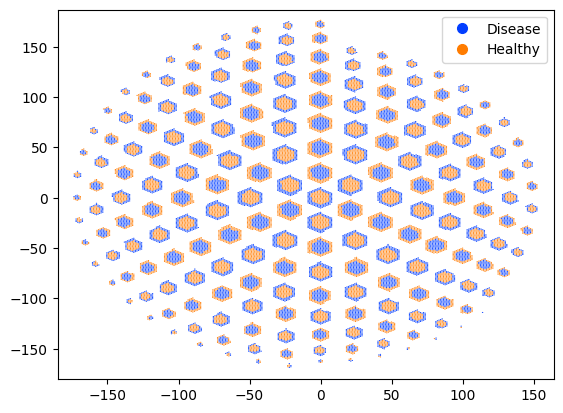

In [529]:
ax=groupdotplot.groupdotplot(df, "CDR3", hue="Condition", n_edge=6, radius=0.5,
                group_firstlap_n=6)
#ax.set(xlim=(-100, 100), ylim=(-100,100))